# ANALYSIS FILE
All processing is done in MAIN.ipynb. Here is just visualisation and fluff

In [17]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import util.validation_testing as val
import util.visualisation as vis
import util.correlation_measure as cm

from scipy.stats import spearmanr, linregress
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm


In [18]:
ANALYSIS_FILENAME = 'results/NEM excl/crqa_NEM-'
RESPONSE_VARIABLE = 'score'
SAVE_FIG = False


PHASES = ['instructional_video_0', 'discussion_phase_0', *[f'reschu_run_{i}' for i in range(4)], 'discussion_phase_1', *[f'reschu_run_{4+i}' for i in range(4)]]
FACTORS = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']

FACTOR_LABELS = {
    'f1': "Enjoyment Smile",
    'f2': "Eyebrows Up",
    'f3': "Mouth Open",
    'f4': "Mouth Tightening",
    'f5': "Eye Tightening",
    'f6': "Mouth Frown"
}

AVAILABLE_PAIRS = ['05_06', '07_08', '09_10', '99_100', '101_102', '103_104', '13_14', '15_16', '17_18', '19_20', '21_22', '25_26', '27_28', '29_30', '31_32', '33_34', '35_36', '37_38', '39_40', '41_42', '43_44', '45_46', '47_48', '49_50', '51_52', '59_60', '61_62', '65_66', '67_68', '69_70', '71_72', '73_74', '75_76', '77_78', '79_80', '81_82', '83_84', '85_86', '87_88', '91_92', '93_94', '95_96', '97_98']

# SCORES OUT OF RESCHU
scores = pd.read_csv('RESCHU-data/teamscores_allParticipants_filtered.csv')
scores = scores[['SubjectId', 'reschuRun', 'TeamTotal']]

RESCHU_DATA = {}
for pair in AVAILABLE_PAIRS:
    p1, _ = pair.split("_")
    df = scores[scores['SubjectId'] == int(p1)]
    score = [[df['reschuRun'].values[i], df['TeamTotal'].values[i]] for i in range(len(df))]
    RESCHU_DATA[pair] = {
        'score' : score,
        'zoom'  : (int(p1)-1)%4 < 2,
        'beeps' : [int(p1) % 4 == 1, int(p1) % 4 != 1] * 4
    }
RESCHU_DATA['51_52']['score'] = [[0, None]] + RESCHU_DATA['51_52']['score'] # because 51_52 misses the score for reschu_run_0

# print example RESCHU data
print(f'Example RESCHU data for pair 51_52: \nscore: {RESCHU_DATA['51_52']['score']}\nzoom: {RESCHU_DATA['51_52']['zoom']}\nbeeps: {RESCHU_DATA['51_52']['beeps']}')



Example RESCHU data for pair 51_52: 
score: [[0, None], [1, 5], [2, 1], [3, 10], [4, 3], [5, 11], [6, 8], [7, 12]]
zoom: False
beeps: [False, True, False, True, False, True, False, True]


# Example and validation of crqa code 

In [37]:
df = pd.read_csv("RESCHU-data/demographics.csv")
df = df[df['ParticipantID']>4]
gender = []
for _, row in df.iterrows():
    if row['Gender'] == 2:
        gender.append("Male")
    else:
        gender.append("Female")
df['Gender'] = gender
print(df['Gender'].value_counts())
print(df['Age'].value_counts())

Gender
Female    69
Male      29
Name: count, dtype: int64
Age
19    20
18    17
20    15
22    13
21     7
23     6
24     5
25     3
26     2
39     1
33     1
36     1
34     1
17     1
32     1
48     1
58     1
62     1
29     1
Name: count, dtype: int64


# Visualisation of the main code

## NEM incl / excl

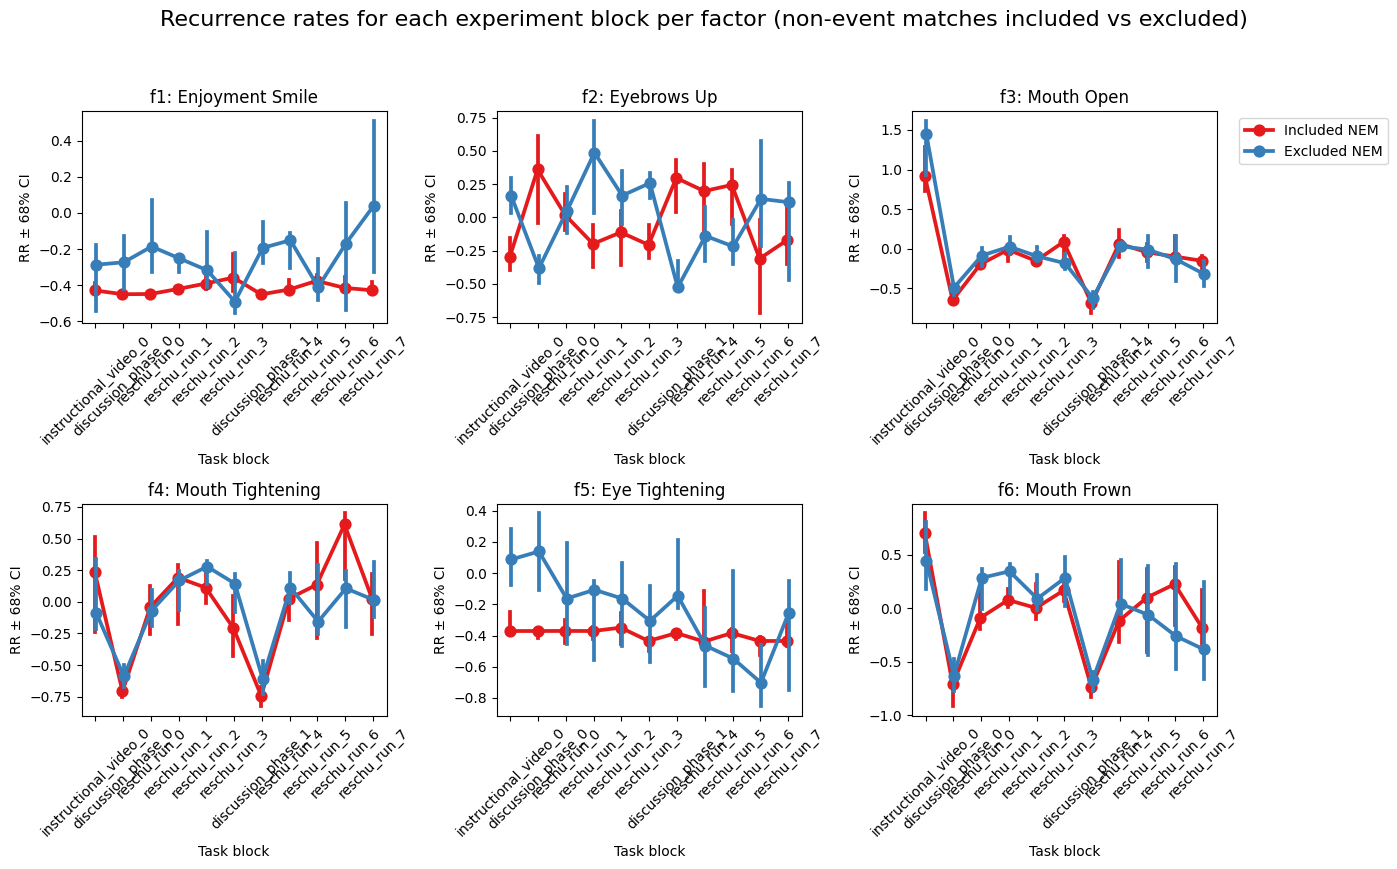

In [20]:
# =====================================================================
# 1. Load and Label Datasets
# =====================================================================
df_incl = pd.read_csv(r'results/NEM incl/crqa_NEM+_overall_questionnaire.csv')
df_excl = pd.read_csv(r'results/NEM excl/crqa_NEM-_overall_questionnaire.csv')

for f in FACTORS:
    df_incl[f] = (df_incl[f] - df_incl[f].mean()) / df_incl[f].std()
    df_excl[f] = (df_excl[f] - df_excl[f].mean()) / df_excl[f].std()
    
# Assume df_incl and df_excl are your two datasets
df_incl['condition'] = 'Included NEM'
df_excl['condition'] = 'Excluded NEM'

# Combine datasets
df_combined = pd.concat([df_incl, df_excl], ignore_index=True)

# Filter and order phases
df_combined = df_combined[df_combined['phase'].isin(PHASES)].copy()
df_combined['phase_ord'] = pd.Categorical(
    df_combined['phase'],
    categories=PHASES,
    ordered=True
)
df_combined['phase_num'] = df_combined['phase_ord'].cat.codes + 1
df_combined = df_combined.reset_index(drop=True)

# Scale variables (independently per condition to preserve relative scaling)
for condition_label in df_combined['condition'].unique():
    condition_mask = df_combined['condition'] == condition_label
    for col in ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', RESPONSE_VARIABLE]:
        mean = df_combined.loc[condition_mask, col].mean()
        std = df_combined.loc[condition_mask, col].std()
        df_combined.loc[condition_mask, f'{col}_scaled'] = (
            df_combined.loc[condition_mask, col] - mean
        ) / std

# =====================================================================
# 2. Visualization
# =====================================================================
plt.figure(figsize=(14, 8))
for i, factor in enumerate(['f1', 'f2', 'f3', 'f4', 'f5', 'f6'], 1):
    plt.subplot(2, 3, i)

    sns.pointplot(
        data=df_combined,
        x='phase_ord',
        y=factor,
        hue='condition',
        estimator=np.median,
        errorbar=('ci', 68),
        dodge=True,
        palette='Set1'
    )

    plt.title(f'{factor}: {FACTOR_LABELS[factor]}')
    plt.xticks(rotation=45)
    plt.xlabel('Task block')
    plt.ylabel("RR ± 68% CI")
    if i == 3:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend().remove()

plt.tight_layout()


plt.suptitle("Recurrence rates for each experiment block per factor (non-event matches included vs excluded)", fontsize=16, y=1.08)
if SAVE_FIG: plt.savefig("img/RR_block_NEM_compared.png", dpi=300, bbox_inches='tight')
plt.show()


## Comparing RR and TP

In [21]:
df = pd.read_csv(f'{ANALYSIS_FILENAME}_overall_questionnaire.csv')
print(df.columns)
# Run tests for each dependent variable
for dep_var in ['score', 'Teamwork', 'Cohesion', 'Cooperation', 'Empathy']:
    print(f"\n{'-'*20}\n{dep_var.upper()}\n{'-'*20}")
    avg_results, phase_results = val.run_significance_tests(df, dep_var)
    
    print("Average:")
    print(avg_results)
    print("\nExcluding intro + discussion. \nInspecting phases individually:")
    print(phase_results)

Index(['Unnamed: 0', 'pair', 'zoom', 'phase', 'beeps', 'score', 'f1', 'f2',
       'f3', 'f4', 'f5', 'f6', 'Teamwork', 'Cohesion', 'Cooperation',
       'Empathy'],
      dtype='object')

--------------------
SCORE
--------------------
Average:
Empty DataFrame
Columns: [setting, component, rho, p]
Index: []

Excluding intro + discussion. 
Inspecting phases individually:
        setting component       rho         p
0    all_reschu        f3  0.271168  0.000017
1    all_reschu        f5 -0.128463  0.044557
2   zoom = True        f3  0.274416  0.001649
3   zoom = True        f5 -0.184668  0.036166
4  zoom = False        f3  0.262645  0.004395
5  reschu_run_1        f3  0.477373  0.002119
6  reschu_run_2        f3  0.487070  0.001436
7  reschu_run_4        f6  0.458405  0.016183

--------------------
TEAMWORK
--------------------
Average:
Empty DataFrame
Columns: [setting, component, rho, p]
Index: []

Excluding intro + discussion. 
Inspecting phases individually:
        setting componen

In [22]:
df = pd.read_csv(f'{ANALYSIS_FILENAME}_overall_questionnaire.csv')
print(np.unique(df['phase'].values))
zoom_new = []
for _, row in df.iterrows():
    zoom_new.append(RESCHU_DATA[row['pair']]['zoom'])
df['zoom'] = zoom_new
df.head()

['discussion_phase_0' 'discussion_phase_1' 'instructional_video_0'
 'reschu_run_0' 'reschu_run_1' 'reschu_run_2' 'reschu_run_3'
 'reschu_run_4' 'reschu_run_5' 'reschu_run_6' 'reschu_run_7']


,Unnamed: 0,pair,zoom,phase,beeps,score,f1,f2,f3,f4,f5,f6,Teamwork,Cohesion,Cooperation,Empathy
0,0,05_06,True,discussion_phase_0,NaN,NaN,0.0187,0.0214,0.0344,0.0295,0.0003,0.0343,NaN,5.6,7.222222,9.956522
1,1,05_06,True,reschu_run_0,True,4.0,0.0288,0.0333,0.0452,0.0491,0.0039,0.0406,184.0,5.6,7.222222,9.956522
2,2,05_06,True,reschu_run_1,False,11.0,0.0298,0.0287,0.0457,0.0521,0.0009,0.0413,200.0,5.6,7.222222,9.956522
3,3,05_06,True,reschu_run_2,True,23.0,0.0347,0.0315,0.0449,0.0404,0.0023,0.0327,200.0,5.6,7.222222,9.956522
4,4,05_06,True,reschu_run_3,False,21.0,0.0098,0.0353,0.0502,0.0452,0.0000,0.0322,200.0,5.6,7.222222,9.956522


### Plotting

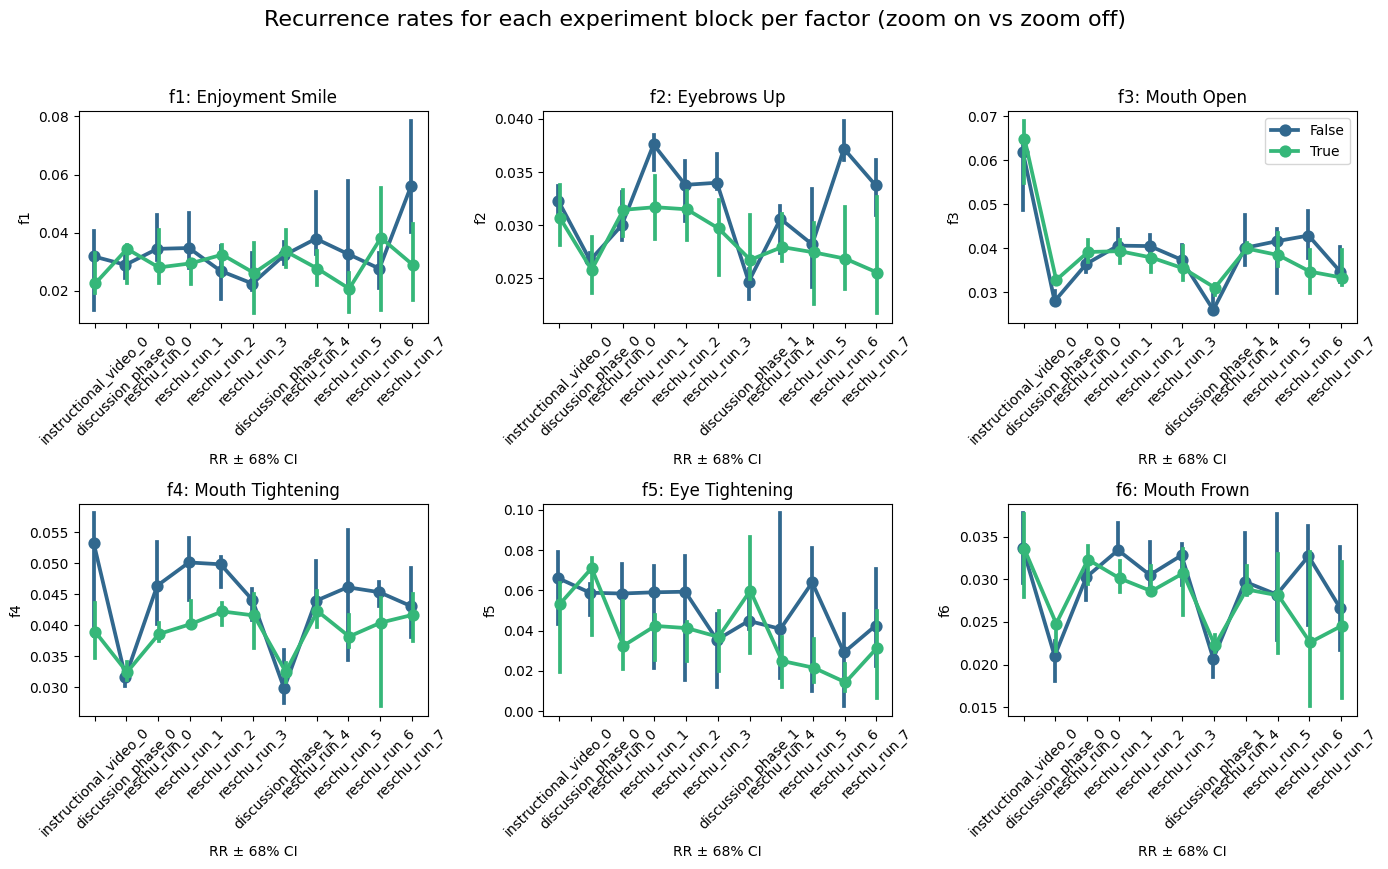

In [23]:
# =====================================================================
# 1. Data Preparation (All Phases)
# =====================================================================

# Filter and order phases
full_df = df[df['phase'].isin(PHASES)].copy()
full_df['phase_ord'] = pd.Categorical(
    full_df['phase'],
    categories=PHASES,
    ordered=True
)
full_df['phase_num'] = full_df['phase_ord'].cat.codes + 1
full_df = full_df.reset_index(drop=True)

# Scale variables
for col in ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', RESPONSE_VARIABLE]:
    full_df[f'{col}_scaled'] = (full_df[col] - full_df[col].mean()) / full_df[col].std()


# =====================================================================
# 3. Visualization
# =====================================================================
plt.figure(figsize=(14, 8))
for i, factor in enumerate(['f1', 'f2', 'f3', 'f4', 'f5', 'f6'], 1):
    plt.subplot(2, 3, i)
    
    sns.pointplot(
        data=full_df,
        x='phase_ord',
        y=factor,
        hue='zoom',
        estimator=np.median,
        errorbar=('ci', 68),
        palette='viridis',
        dodge=True
    )
    
    plt.title(f'{factor}: {FACTOR_LABELS[factor]}')
    plt.xticks(rotation=45)
    plt.xlabel('Task Block')
    
    plt.xlabel('RR ± 68% CI')
    if i == 3:
        plt.legend(bbox_to_anchor=(1, 1))
    else:
        plt.legend().remove()

plt.tight_layout()
plt.suptitle("Recurrence rates for each experiment block per factor (zoom on vs zoom off)", fontsize=16, y=1.08)
if SAVE_FIG: plt.savefig("img/FACE_per_phase.png", dpi=300, bbox_inches='tight')
plt.show()


In [24]:
# =====================================================================
# 2. Mixed-Effects Models (All Phase Effects)
# =====================================================================

all_results = []

if 'pair' not in full_df.columns:
    raise ValueError("Missing 'pair' column in your dataframe.")

for factor in ['f1_scaled', 'f2_scaled', 'f3_scaled', 'f4_scaled', 'f5_scaled', 'f6_scaled']:
    formula = f"{factor} ~ phase_ord * zoom"
    try:
        model = mixedlm(formula, data=full_df, groups=full_df["pair"])
        fit = model.fit()

        # Extract coefficients and p-values
        coef_table = pd.DataFrame({
            'term': fit.params.index,
            'coef': fit.params.values,
            'pval': fit.pvalues.values
        })

        # Filter only phase and interaction terms
        phase_terms = coef_table[coef_table['term'].str.startswith('phase_ord')]
        phase_terms['factor'] = factor

        all_results.append(phase_terms)

    except Exception as e:
        print(f"Error fitting model for {factor}: {e}")

# Combine results
if all_results:
    combined_results = pd.concat(all_results, ignore_index=True)
    print("\nMixed-Effects Coefficients by Phase:")
    print(combined_results[['factor', 'term', 'coef', 'pval']])
    print(combined_results[combined_results['pval'] < 0.05])
else:
    print("No model results were collected.")

C:\Users\Erik\AppData\Local\Temp\ipykernel_30012\3533597987.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_terms['factor'] = factor
C:\Users\Erik\AppData\Local\Temp\ipykernel_30012\3533597987.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_terms['factor'] = factor
C:\Users\Erik\AppData\Local\Temp\ipykernel_30012\3533597987.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 


Mixed-Effects Coefficients by Phase:
        factor                                          term      coef  \
0    f1_scaled               phase_ord[T.discussion_phase_0] -0.354238   
1    f1_scaled                     phase_ord[T.reschu_run_0] -0.057720   
2    f1_scaled                     phase_ord[T.reschu_run_1] -0.012505   
3    f1_scaled                     phase_ord[T.reschu_run_2] -0.160367   
4    f1_scaled                     phase_ord[T.reschu_run_3] -0.083757   
..         ...                                           ...       ...   
115  f6_scaled  phase_ord[T.discussion_phase_1]:zoom[T.True]  0.260096   
116  f6_scaled        phase_ord[T.reschu_run_4]:zoom[T.True] -0.264620   
117  f6_scaled        phase_ord[T.reschu_run_5]:zoom[T.True] -0.476500   
118  f6_scaled        phase_ord[T.reschu_run_6]:zoom[T.True] -1.074619   
119  f6_scaled        phase_ord[T.reschu_run_7]:zoom[T.True] -0.579786   

         pval  
0    0.075752  
1    0.769171  
2    0.950092  
3    0.42

C:\Users\Erik\AppData\Local\Temp\ipykernel_30012\3533597987.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_terms['factor'] = factor


Mixed Effects Model Results:

f1_scaled: coef = 0.0114, p = 0.897
f2_scaled: coef = 0.0318, p = 0.6456
f3_scaled: coef = 0.2622, p = 0.0001506
f4_scaled: coef = 0.1461, p = 0.04258
f5_scaled: coef = -0.0734, p = 0.3742
f6_scaled: coef = 0.1077, p = 0.1361


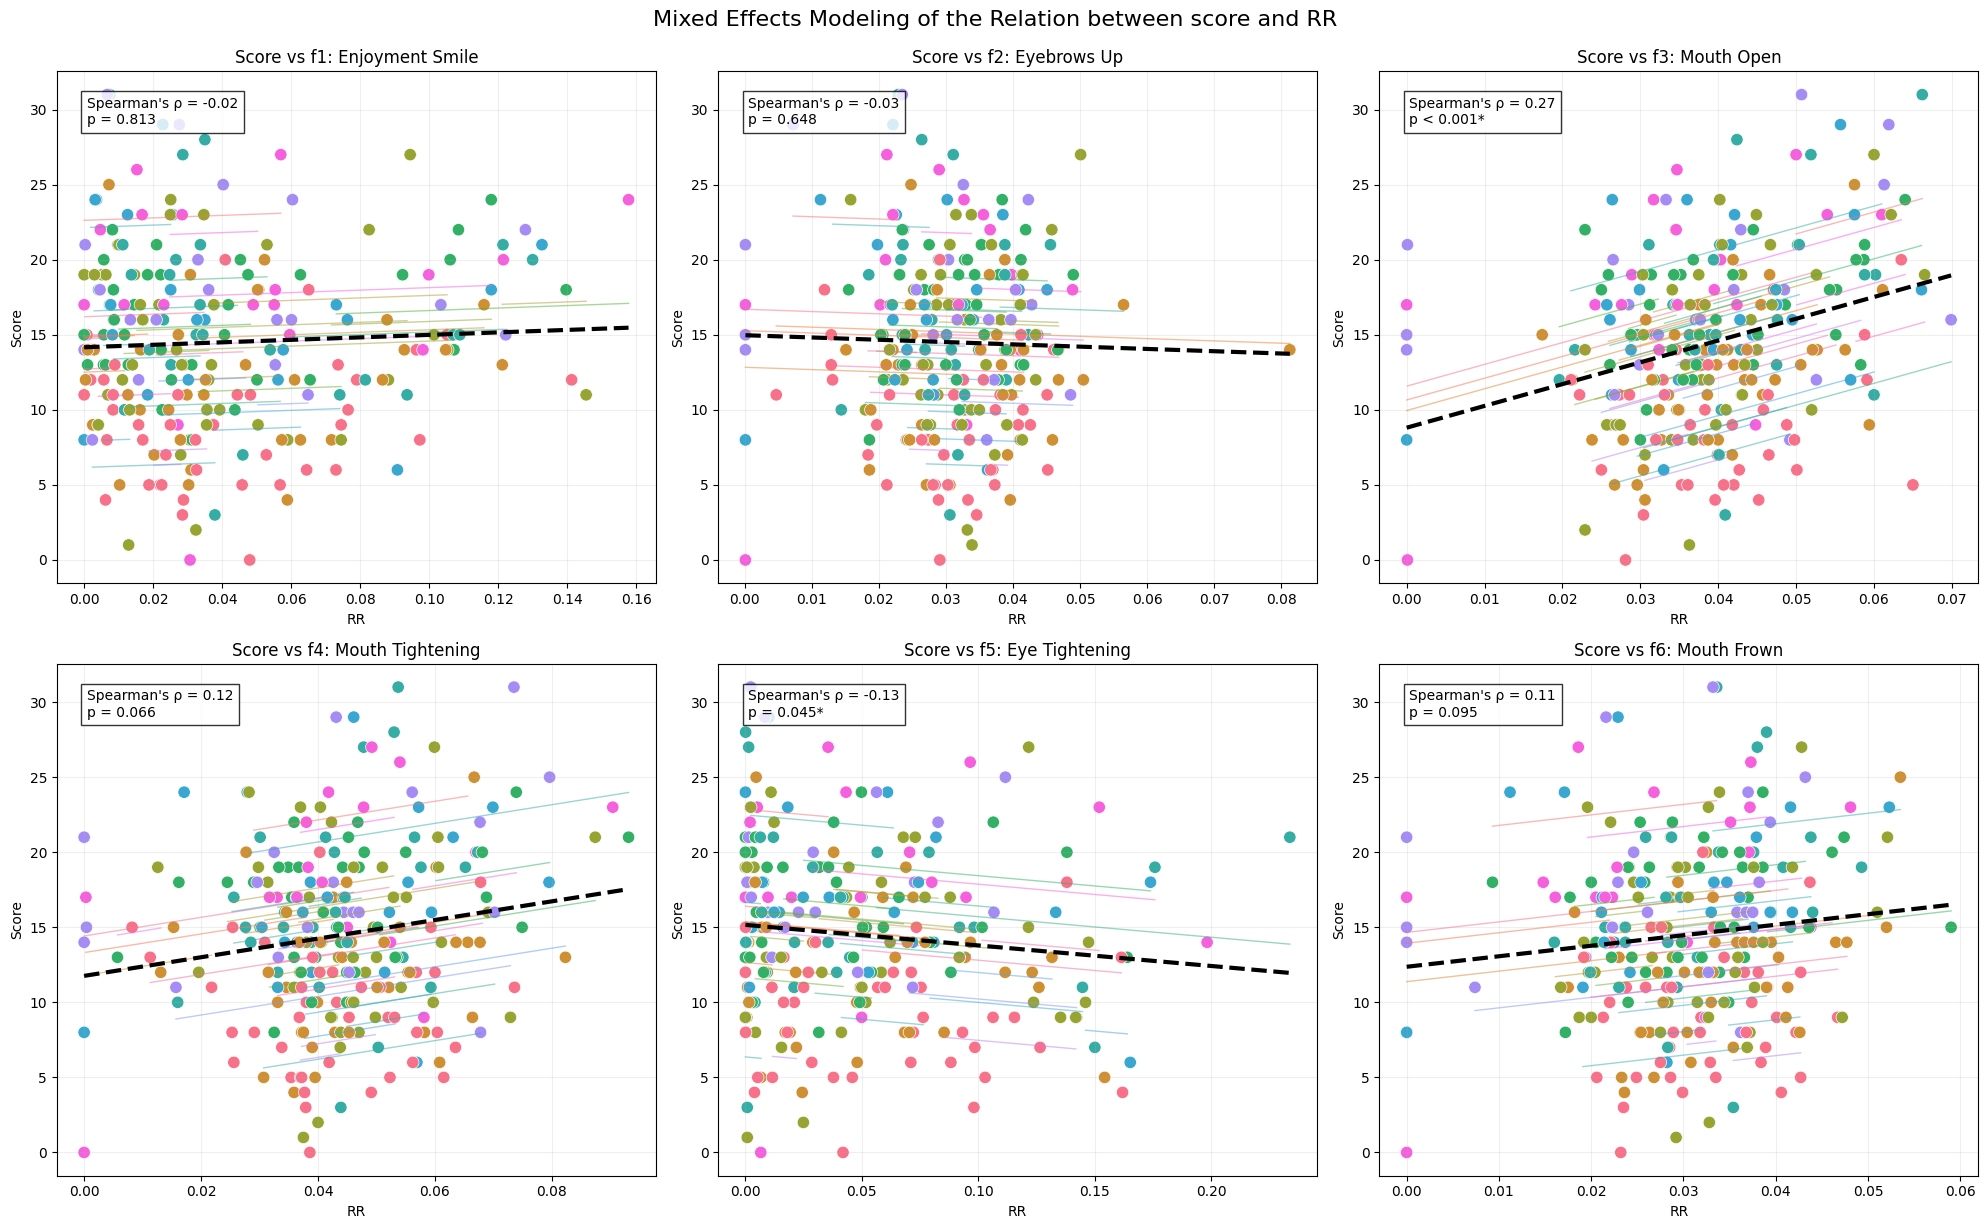

In [25]:
# ==== 1. Filter for reschu runs ====

reschu_df = df[df['phase'].str.contains('reschu_run')].copy()
reschu_df['run_number'] = [row['phase'][-1] for _,row in reschu_df.iterrows()]

# Check participant/group ID column:
if 'pair' not in reschu_df.columns:
    raise ValueError("Please ensure your dataframe contains a 'pair' column for participant grouping.")

pairs = reschu_df['pair'].unique()
palette = sns.color_palette("husl", len(pairs))
pair_colors = dict(zip(pairs, palette))

# ==== 2. Scale predictors and outcome ====
for col in ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', RESPONSE_VARIABLE]:
    reschu_df[f'{col}_scaled'] = (reschu_df[col] - reschu_df[col].mean()) / reschu_df[col].std()

predictors = ['f1_scaled', 'f2_scaled', 'f3_scaled', 'f4_scaled', 'f5_scaled', 'f6_scaled']
reschu_df = reschu_df.dropna(subset=[RESPONSE_VARIABLE])

# ==== 3. Mixed Effects Models ====
print("Mixed Effects Model Results:\n")
results = []
for factor in predictors:
    formula = f"{RESPONSE_VARIABLE}_scaled ~ {factor}"
    try:
        model = smf.mixedlm(formula, data=reschu_df, groups=reschu_df['pair'])
        fit = model.fit()
        coef = fit.params[factor]
        pval = fit.pvalues[factor]
        results.append({'factor': factor, 'coef': coef, 'pval': pval})
        print(f"{factor}: coef = {coef:.4f}, p = {pval:.4g}")
    except Exception as e:
        print(f"Error fitting model for {factor}: {e}")

results_df = pd.DataFrame(results)

# ==== 4. Plot all factors in subplots ====

plt.figure(figsize=(20, 12))

for i, factor in enumerate(predictors, 1):
    plt.subplot(2, 3, i)
    
    # Use original (unscaled) factor and score for plotting clarity
    orig_factor = factor.replace('_scaled', '')
    
    # Spearman correlation for annotation
    rho, p = spearmanr(reschu_df[orig_factor], reschu_df[RESPONSE_VARIABLE])
    p_text = "p < 0.001*" if p < 0.001 else f"p = {p:.3f}*" if p<0.05 else  f"p = {p:.3f}"
    
    # Global linear regression on original data
    global_slope, global_intercept, _, _, _ = linregress(reschu_df[orig_factor], reschu_df[RESPONSE_VARIABLE])
    
    # Scatter points, colored by run number
    sns.scatterplot(
        data=reschu_df,
        x=orig_factor,
        y=RESPONSE_VARIABLE,
        hue='run_number',
        palette='husl',
        s=80,
        edgecolor='w',
        linewidth=0.5,
        legend=False
    )
    
    # Per-pair regression lines: common slope, individual intercept
    for pair in pairs:
        pair_data = reschu_df[reschu_df['pair'] == pair]
        pair_intercept = np.mean(pair_data[RESPONSE_VARIABLE] - global_slope * pair_data[orig_factor])
        x_vals = np.array([pair_data[orig_factor].min(), pair_data[orig_factor].max()])
        y_vals = pair_intercept + global_slope * x_vals
        plt.plot(x_vals, y_vals, color=pair_colors[pair], alpha=0.5, lw=1)
    
    # Global regression line (bold dashed)
    x_global = np.linspace(reschu_df[orig_factor].min(), reschu_df[orig_factor].max(), 100)
    y_global = global_intercept + global_slope * x_global
    plt.plot(x_global, y_global, color='black', lw=3, linestyle='--', label=f'Global Slope (β={global_slope:.2f})')
    
    # Add Spearman correlation annotation
    plt.text(
        0.05, 0.95,
        f"Spearman's ρ = {rho:.2f}\n{p_text}",
        transform=plt.gca().transAxes,
        va='top', ha='left',
        bbox=dict(facecolor='white', alpha=0.8)
    )
    
    plt.title(f'{RESPONSE_VARIABLE.capitalize()} vs {orig_factor}: {FACTOR_LABELS[orig_factor]}')
    plt.xlabel('RR')
    plt.ylabel(RESPONSE_VARIABLE.capitalize())
    plt.grid(alpha=0.2)

plt.tight_layout()
plt.suptitle(f"Mixed Effects Modeling of the Relation between {RESPONSE_VARIABLE} and RR", fontsize=16, y=1.02)
if SAVE_FIG: plt.savefig(f"img/{RESPONSE_VARIABLE}_x_FACE.png", dpi=300, bbox_inches='tight')
plt.show()


### Check distributions

Mixed Model Results:
  factor  global_slope  global_p  zoom_slope    zoom_p
0     f1      0.050596  0.657889   -0.088198  0.616077
1     f2      0.064766  0.537529   -0.058736  0.672300
2     f3      0.369109  0.004111   -0.144553  0.338931
3     f4      0.118552  0.334563    0.050824  0.738787
4     f5     -0.011107  0.919067   -0.147734  0.367194
5     f6      0.135477  0.274615   -0.040313  0.791670


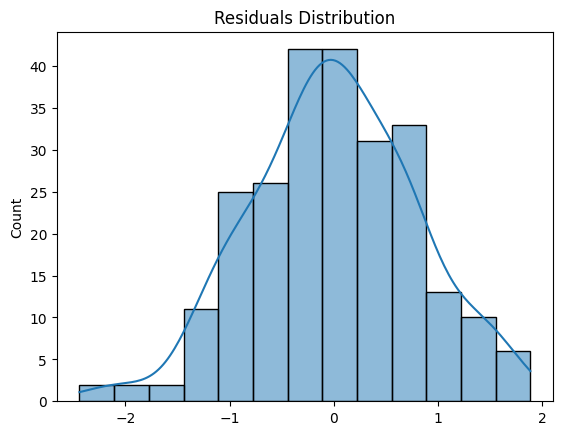

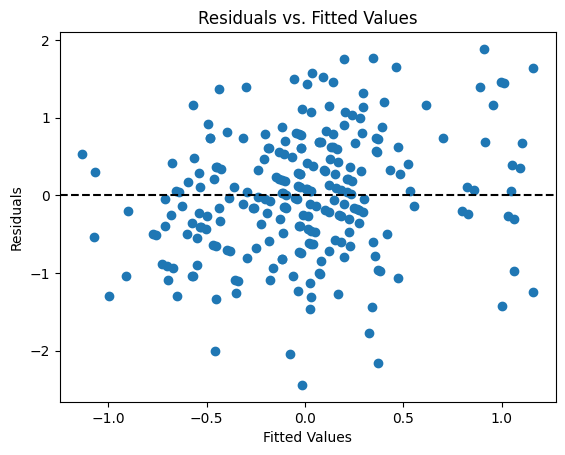

Pseudo R-squared score for the model: 0.2866


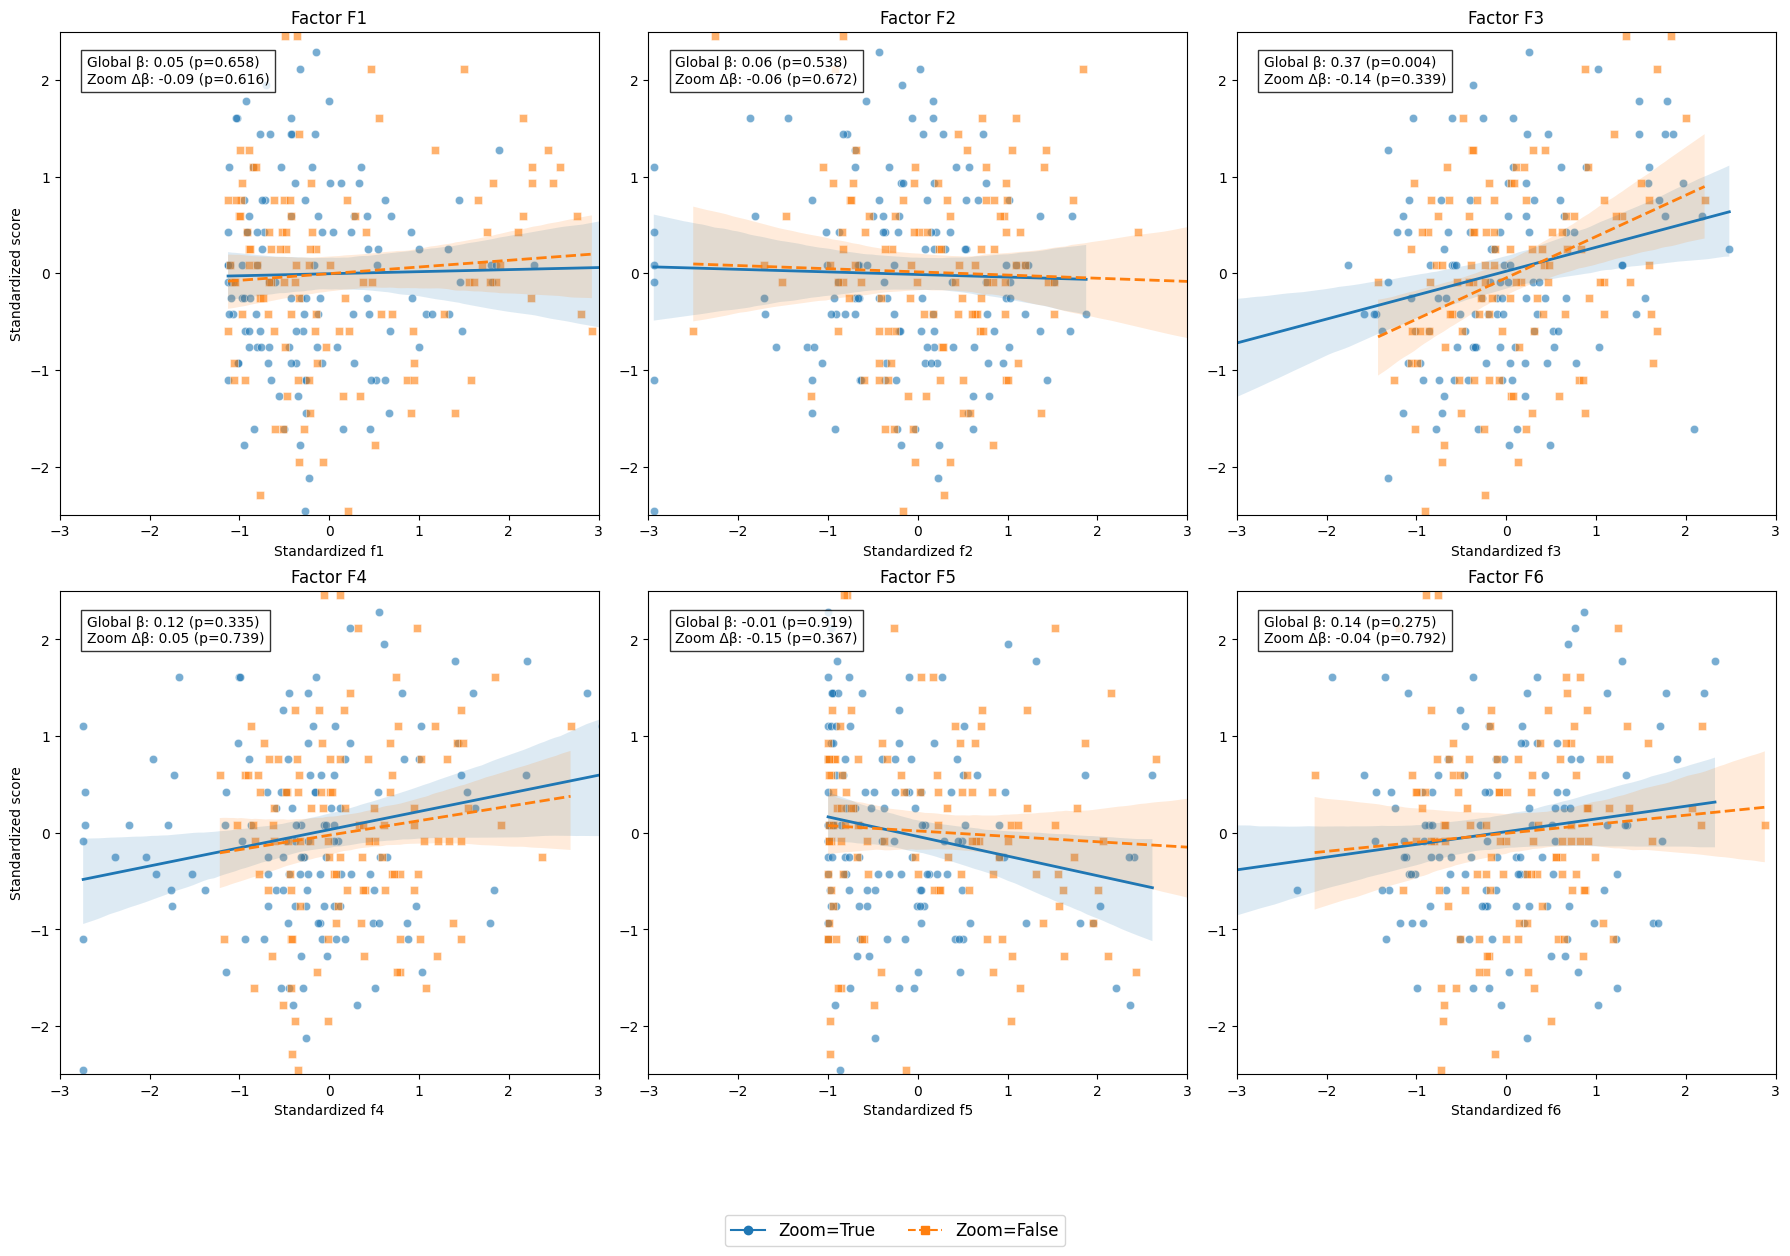

In [26]:
# Prepare data - Only RESCHU phases
reschu_df = df[df['phase'].str.contains('reschu_run')].copy()
factors = ['f1', 'f2','f3', 'f4', 'f5', 'f6']
reschu_df = reschu_df.dropna(subset=[RESPONSE_VARIABLE])

# 1. Standardization
for factor in factors + [RESPONSE_VARIABLE]:
    reschu_df[f'{factor}_std'] = (reschu_df[factor] - reschu_df[factor].mean()) / reschu_df[factor].std()

# 2. Mixed-effects modeling with random intercepts
results = []
for factor in factors:
    # Model formula (fixed effects only)
    formula = f"{RESPONSE_VARIABLE}_std ~ {factor}_std * zoom"
    
    # Fit model with random intercepts per pair
    model = smf.mixedlm(
        formula,
        data=reschu_df,
        groups=reschu_df['pair'],  # Random intercepts by pair
        re_formula='1'            # Explicit random intercept specification
    ).fit(reml=False)
    
    # Store results
    params = model.params
    pvals = model.pvalues
    results.append({
        'factor': factor,
        'zoom_slope': params[f'{factor}_std:zoom[T.True]'],
        'zoom_p': pvals[f'{factor}_std:zoom[T.True]'],
        'global_slope': params[f'{factor}_std'],
        'global_p': pvals[f'{factor}_std']
    })

# 3. Create results table
results_df = pd.DataFrame(results)
print("Mixed Model Results:")
print(results_df[['factor', 'global_slope', 'global_p', 'zoom_slope', 'zoom_p']])

# 4. Check residuals for normality
# Get the residuals from the model (assuming you want to check the residuals from the last fitted model)
residuals = model.resid

# Check normality with a histogram and KDE (Kernel Density Estimate)
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

# 5. Check for heteroscedasticity (Residuals vs Fitted Values)
# Get the fitted values from the model
fitted_values = model.fittedvalues

# Plot residuals vs. fitted values to check for heteroscedasticity
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

# 6. Calculate pseudo R-squared (variance components)
variance_components = model.cov_re.iloc[0, 0]  # Variance of random intercepts
residual_variance = model.scale  # Residual variance
total_variance = variance_components + residual_variance

# Pseudo R-squared
pseudo_r_squared = variance_components / total_variance
print(f"Pseudo R-squared {RESPONSE_VARIABLE} for the model: {pseudo_r_squared:.4f}")

# 7. Create unified figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()  # Flatten to 1D array for easier indexing

# Common formatting
colors = {'True': '#1f77b4', 'False': '#ff7f0e'}
markers = {'True': 'o', 'False': 's'}
x_range = (-3, 3)  # For standardized factors
y_range = (-2.5, 2.5)  # For standardized scores

for idx, factor in enumerate(factors):
    ax = axs[idx]
    
    # Plot data points
    for zoom_condition in [True, False]:
        subset = reschu_df[reschu_df['zoom'] == zoom_condition]
        ax.scatter(
            subset[f'{factor}_std'],
            subset[f'{RESPONSE_VARIABLE}_std'],
            c=colors[str(zoom_condition)],
            marker=markers[str(zoom_condition)],
            alpha=0.6,
            edgecolor='w',
            linewidth=0.5,
            label=f'Zoom={zoom_condition}'
        )
    
    # Plot regression lines
    for zoom_condition in [True, False]:
        subset = reschu_df[reschu_df['zoom'] == zoom_condition]
        sns.regplot(
            x=subset[f'{factor}_std'],
            y=subset[f'{RESPONSE_VARIABLE}_std'],
            ax=ax,
            color=colors[str(zoom_condition)],
            scatter=False,
            ci=95,
            line_kws={'lw':2, 'ls':'-' if zoom_condition else '--'}
        )
    
    # Add model annotations
    res = results_df[results_df['factor'] == factor].iloc[0]
    text = (f"Global β: {res['global_slope']:.2f} (p={res['global_p']:.3f})\n"
            f"Zoom Δβ: {res['zoom_slope']:.2f} (p={res['zoom_p']:.3f})")
    ax.text(0.05, 0.95, text, transform=ax.transAxes,
            va='top', ha='left', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8))
    
    # Format axes
    ax.set(xlim=x_range, ylim=y_range,
           xlabel=f'Standardized {factor}',
           ylabel=f'Standardized {RESPONSE_VARIABLE}' if idx in [0,3] else '',
           title=f'Factor {factor.upper()}')

# Create unified legend
handles = [
    plt.Line2D([], [], color=colors['True'], marker='o', ls='-', label='Zoom=True'),
    plt.Line2D([], [], color=colors['False'], marker='s', ls='--', label='Zoom=False')
]
fig.legend(handles=handles, loc='lower center', ncol=2, 
           bbox_to_anchor=(0.5, -0.05), fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Make space for legend
if SAVE_FIG: plt.savefig(f"img/{RESPONSE_VARIABLE}_zoom_FACE.png", dpi=300, bbox_inches='tight')
plt.show()


# Archived: delay analysis

if False:
    import util.visualisation as vis
    import pandas as pd
    df = pd.read_csv(f'{ANALYSIS_FILENAME}_profile.csv')
    vis.delay_profile(df)

# Illustrative examples

Downsampling from 7200 to 1200 points using mean over bins of size 6
Final radius: 0.0200
Max RR: 1.0000
Min RR: 0.0105


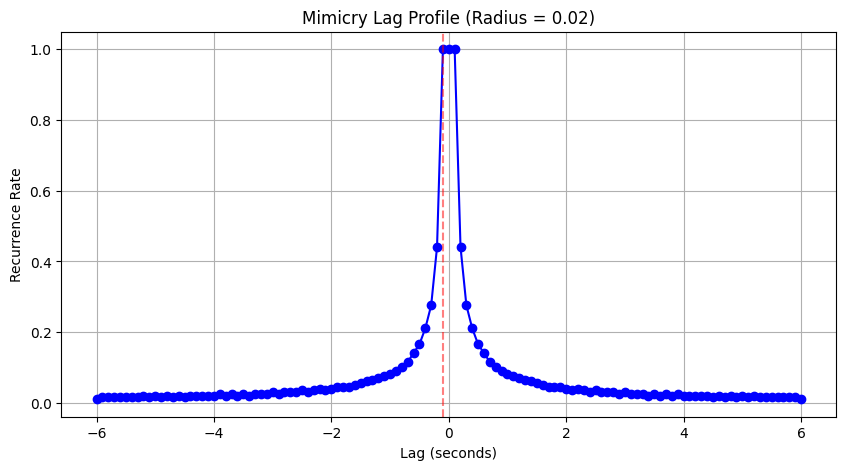

c:\Users\Erik\Documents\facial-expression-synchrony\util\visualisation.py:368: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


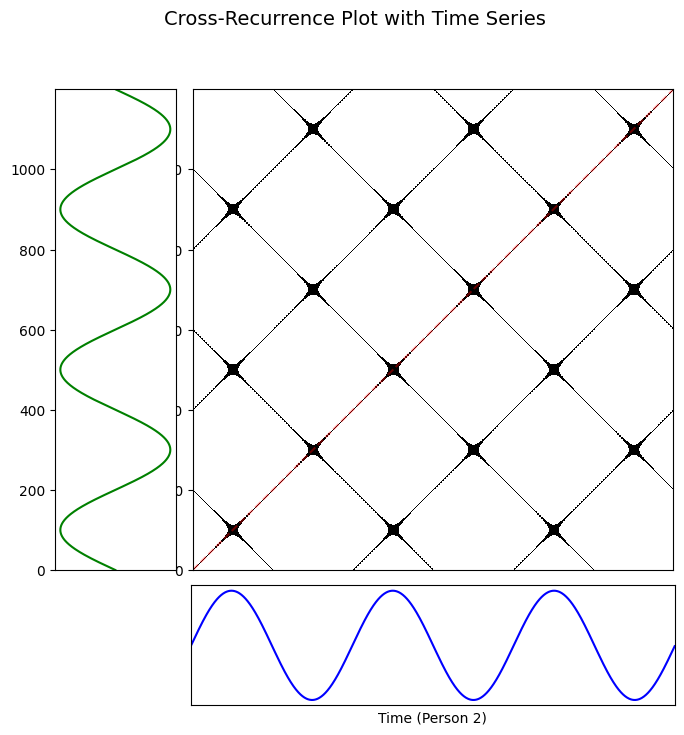

Downsampling from 7200 to 1200 points using mean over bins of size 6
Final radius: 0.0200
Max RR: 0.0588
Min RR: 0.0138


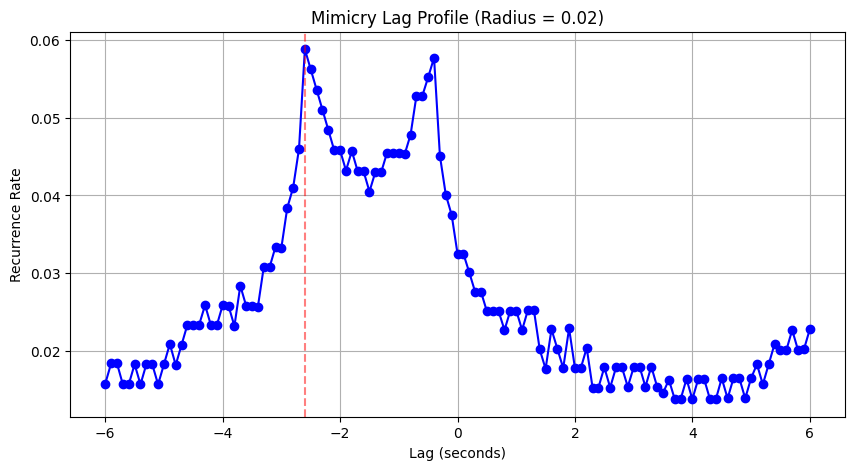

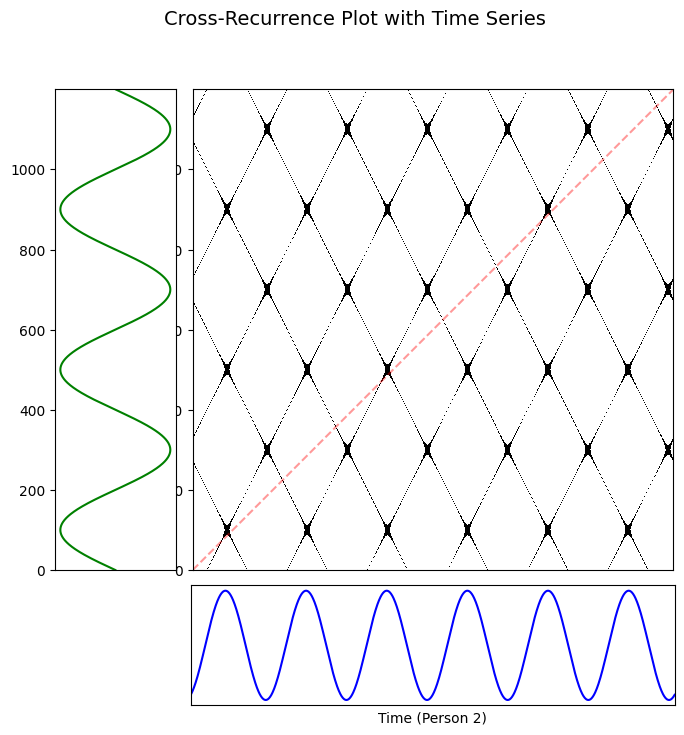

Downsampling from 7200 to 1200 points using mean over bins of size 6
Final radius: 0.5000
Max RR: 0.4257
Min RR: 0.3779


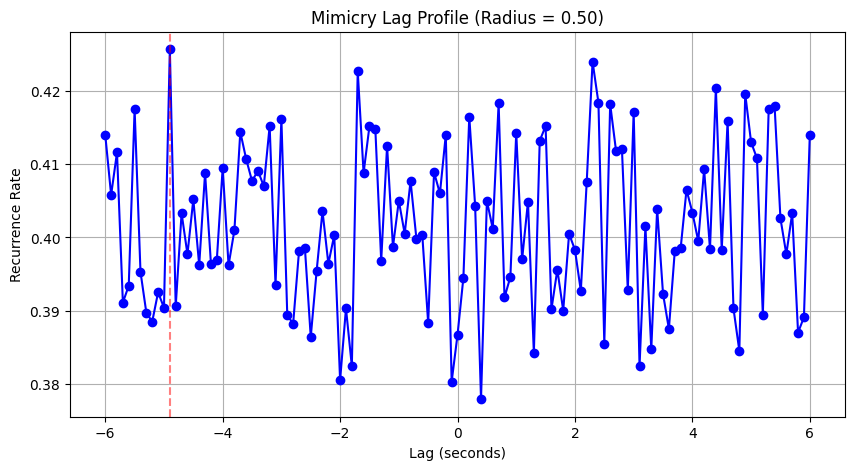

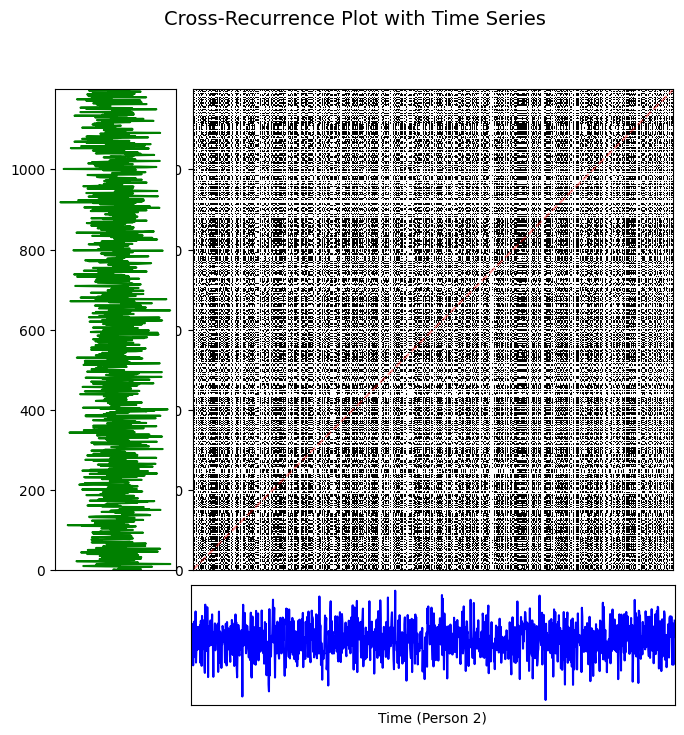

Downsampling from 7200 to 1200 points using mean over bins of size 6
Final radius: 0.5000
Max RR: 0.0000
Min RR: 0.0000


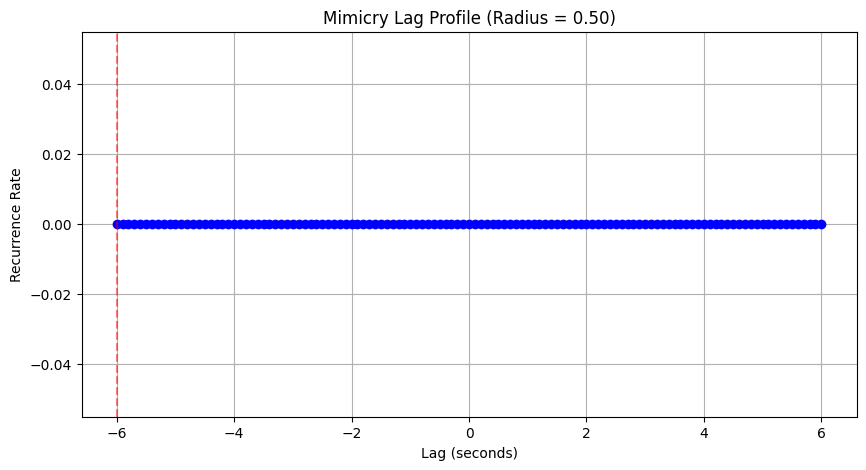

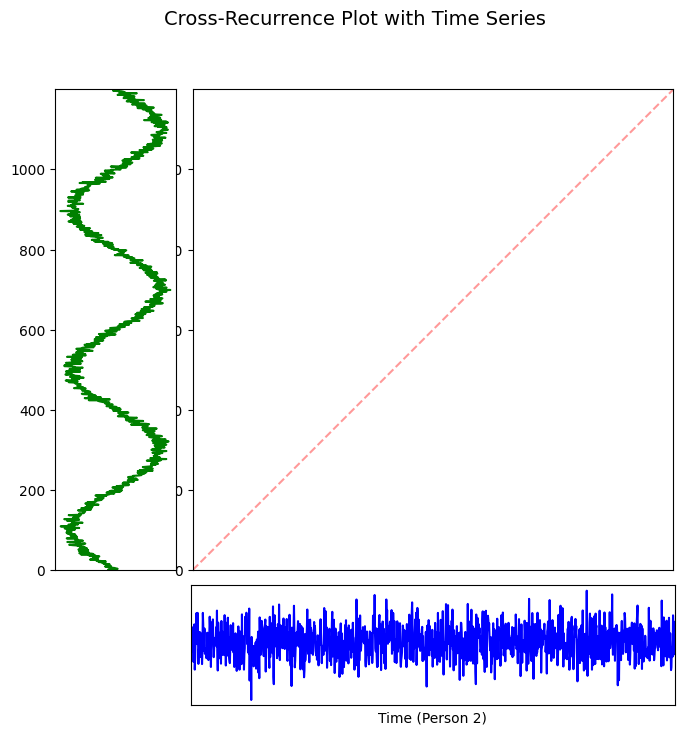

Downsampling from 7200 to 1200 points using mean over bins of size 6
Final radius: 0.5000
Max RR: 0.0442
Min RR: 0.0000


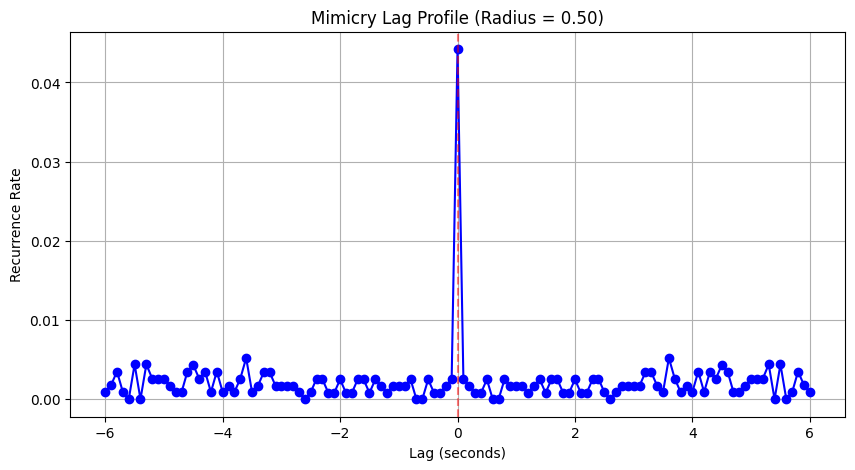

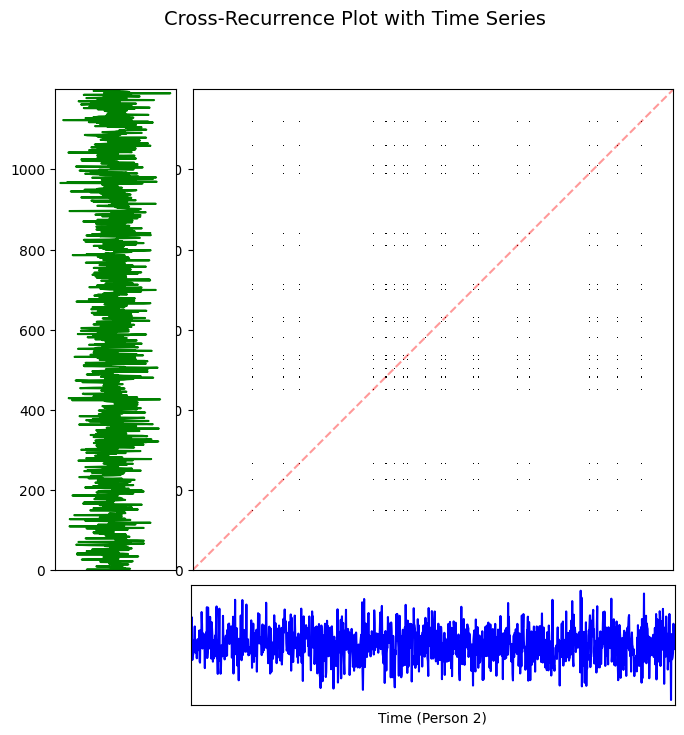

RR for synchronous signal: 0.0287
RR for delayed signal: 0.3993
RR for random signal: 0.3993
RR for random signal with sinus: 0.0
RR for constant signal: 0.002


In [38]:
# Two identical sine waves with noise
np.random.seed(42)

# Set duration and sampling rate
duration_seconds = 120  # 2 minutes
sampling_rate = 60  # 60 Hz
n_samples = duration_seconds * sampling_rate

# Correct time vector for 2 minutes at 60Hz
t = np.linspace(0, duration_seconds, n_samples, endpoint=False)

# Now build your signals
signal = np.sin(0.5 * np.pi * 0.1 * t) + 5  # base sine wave + offset
noise = np.random.randn(n_samples) / 10


p1 = signal 
p2 = signal
result = cm.crqa_lag_analysis(p1, p2, sampling_rate=60,debug=True, radius=0.02, remove_non_event_matches=False)
vis.plot_crp_with_signals(p1=result['recurrence'].shape[0] and p1[::6], 
                      p2=result['recurrence'].shape[1] and p2[::6], 
                      recurrence_matrix=result['recurrence'])

sync = result['RR']
# Two sine waves with 0.5s delay
delay_seconds = 3.5
delay_samples = int(delay_seconds * 60)  # at 60Hz

p1 = signal 
p2 = np.sin(1 * np.pi * 0.1 * (t - delay_seconds)) + 5

result = cm.crqa_lag_analysis(p1, p2, sampling_rate=60,debug=True, radius=0.02, remove_non_event_matches=True)
vis.plot_crp_with_signals(p1=result['recurrence'].shape[0] and p1[::6], 
                      p2=result['recurrence'].shape[1] and p2[::6], 
                      recurrence_matrix=result['recurrence'])

delay = result['RR']
# Two independent random signals
p1 = np.random.randn(len(t))
p2 = np.random.randn(len(t))

result = cm.crqa_lag_analysis(p1, p2, sampling_rate=60,debug=True, radius=0.5, remove_non_event_matches=True)
vis.plot_crp_with_signals(p1=result['recurrence'].shape[0] and p1[::6], 
                      p2=result['recurrence'].shape[1] and p2[::6], 
                      recurrence_matrix=result['recurrence'])

random = result['RR']

delay = result['RR']
# Two independent random signals
p1 = signal + noise
p2 = np.random.randn(len(t))

result = cm.crqa_lag_analysis(p1, p2, sampling_rate=60,debug=True, radius=0.5, remove_non_event_matches=True)
vis.plot_crp_with_signals(p1=result['recurrence'].shape[0] and p1[::6], 
                      p2=result['recurrence'].shape[1] and p2[::6], 
                      recurrence_matrix=result['recurrence'])

split = result['RR']

p1 = noise
p2 = noise

result = cm.crqa_lag_analysis(p1, p2, sampling_rate=60,debug=True, radius=0.5, remove_non_event_matches=True)
vis.plot_crp_with_signals(p1=result['recurrence'].shape[0] and p1[::6], 
                      p2=result['recurrence'].shape[1] and p2[::6], 
                      recurrence_matrix=result['recurrence'])

const = result['RR']


print(f"RR for synchronous signal: {sync}")
print(f"RR for delayed signal: {delay}")
print(f"RR for random signal: {random}")
print(f"RR for random signal with sinus: {split}")
print(f"RR for constant signal: {const}")
